In [1]:
import tensorflow as tf
tf.config.gpu.set_per_process_memory_fraction(.3)
tf.config.gpu.set_per_process_memory_growth(True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Activation,Dropout, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import copy

The target values are: [[0]
 [0]
 [0]
 [1]]
The predicted values are: [[0.00118378]
 [0.03063481]
 [0.03063481]
 [0.49546265]]


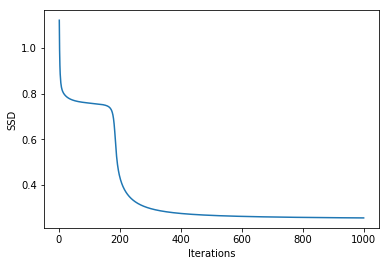

In [40]:
# Logic Operator
# Sigmoid function
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

# derivative of Sigmoid function for backprop.
def sigmoid_derivative(x):
    return x * (1.0 - x)

class NeuralNetwork:
    def __init__(self, x, y, N):
        self.input    = x
        self.neuron   = N
        self.weights1 = np.random.rand(self.input.shape[1], self.neuron) # X dimension input connected to N neurons
        self.weights2 = np.random.rand(self.neuron, 1)                   # N neurons connected to output            
        self.y        = y
        self.output   = np.zeros(self.y.shape)                # instantiating the output

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1)) 
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # Chain rule to calculate derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T,
                            (2*(self.y - self.output)
                            * sigmoid_derivative(self.output)))
        
        d_weights1 = np.dot(self.input.T,
                            (np.dot(2*(self.y - self.output)
                            * sigmoid_derivative(self.output),
                            self.weights2.T) * sigmoid_derivative(self.layer1)))

        # weights updating
        self.weights1 += d_weights1
        self.weights2 += d_weights2


iterations = 1000
n_unit = 1

if __name__ == "__main__": 
    #AND DATA
    Input = np.array([[0,0,1],
                      [0,1,1],
                      [1,0,1],
                      [1,1,1]])
    
    Target = np.array([[0],[0],[0],[1]])

    model = NeuralNetwork(Input, Target, n_unit)
    
    SSD = []
    for i in range(iterations):
        model.feedforward()
        model.backprop()
        errors = (Target - model.output)**2
        SSD.append(np.sum(errors))            # Objective(loss) function
                      

    Itr = np.linspace(1,len(SSD),len(SSD))    
    plt.plot(Itr, SSD)
    plt.xlabel('Iterations')
    plt.ylabel('SSD')
    print("The target values are:", Target)
    print("The predicted values are:", model.output)

The target values are: [[0]
 [1]
 [1]
 [0]]
The predicted values are: [[0.99999328]
 [0.99999943]
 [0.99999964]
 [0.99999996]]


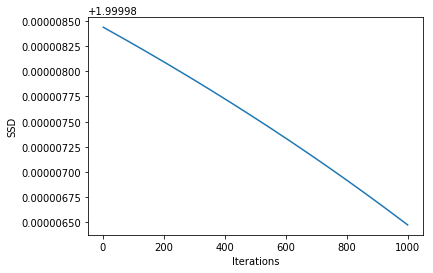

In [48]:
iterations = 1000
n_unit = 50
# XOR DATA
Input = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]])

Target = np.array([[0],[1],[1],[0]])


model = NeuralNetwork(Input, Target, n_unit)

SSD = []
for i in range(iterations):
    model.feedforward()
    model.backprop()
    errors = (Target - model.output)**2
    SSD.append(np.sum(errors))            # Objective(loss) function


Itr = np.linspace(1,len(SSD),len(SSD))    
plt.plot(Itr, SSD)
plt.xlabel('Iterations')
plt.ylabel('SSD')
print("The target values are:", Target)
print("The predicted values are:", model.output)

### Question 1 
- Results will change a little bit as a result of randomness in weights initialization. However it won't change much as we train for 1000 iteration and the loss will got saturated. 
- With increasing number of iterations, loss goes down. But we can observe that the loss will start to saturate at 500 iterations.  

### Question2
- AND operator has lower loss values. Because if we draw it graphically, we will see for AND operator, we only need a line to separate between two class. However for XOR operator, we need ellipse to separate between two class which means we need non linearity in our model and we only have one neuron in the hidden layer which is not that much of non linearity. 
- Increasing number of neurons improves results because we allow for more non linearity in our model. 


In [4]:
# Logic operator with Tensorflow Keras
Input = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")
Target = np.array([[0],[1],[1],[0]], "float32")
n_unit = 10

model = Sequential()
model.add(Dense(n_unit, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer = SGD(lr=1),
              metrics=['binary_accuracy'])

model.fit(Input, Target, epochs = 5000, verbose=0)

print("The predicted class labels are:", model.predict(Input))

The predicted class labels are: [[0.01653087]
 [0.9944931 ]
 [0.99331427]
 [0.00487065]]


### Question 3
- With lower number of units, the predicted results will be around .5 for each data point which is just a random prediction. With increasing the number of units, the models tries to get closer to the actual output. 
- Also with increasing the learning rate, model gets better faster. 

In [3]:
# Data Loader
# Assigning labels two images; those images contains pattern1 in their filenames
# will be labeled as class 0 and those with pattern2 will be labeled as class 1.
def gen_labels(im_name, pat1, pat2):
        if pat1 in im_name:
            Label = np.array([0])
        elif pat2 in im_name:
            Label = np.array([1])
        return Label

# reading and resizing the training images with their corresponding labels
def train_data(train_data_path, train_list, img_w, img_h, pattern1, pattern2):
    train_img = []       
    for i in range(len(train_list)):
        image_name = train_list[i]
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img.append([np.array(img), gen_labels(image_name, pattern1, pattern2)]) 
        
        if i % 200 == 0:
             print('Reading: {0}/{1}  of train images'.format(i, len(train_list)))
             
    shuffle(train_img)
    return train_img

# reading and resizing the testing images with their corresponding labels
def test_data(test_data_path, test_list, img_w, img_h, pattern1, pattern2):
    test_img = []       
    for i in range(len(test_list)):
        image_name = test_list[i]
        img = imread(os.path.join(test_data_path, image_name), as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img.append([np.array(img), gen_labels(image_name, pattern1, pattern2)]) 
        
        if i % 100 == 0:
            print('Reading: {0}/{1} of test images'.format(i, len(test_list)))
             
    shuffle(test_img)   
    return test_img

# Instantiating images and labels for the model.
def get_train_test_data(train_data_path, test_data_path, train_list, test_list, img_w, img_h, pattern1, pattern2):
    
    Train_data = train_data(train_data_path, train_list, img_w, img_h, pattern1, pattern2)
    Test_data = test_data(test_data_path, test_list, img_w, img_h, pattern1, pattern2)
       
    Train_Img = np.zeros((len(train_list), img_h, img_w), dtype = np.float32)
    Test_Img = np.zeros((len(test_list), img_h, img_w), dtype = np.float32)
    
    Train_Label = np.zeros((len(train_list)), dtype = np.int32)
    Test_Label = np.zeros((len(test_list)), dtype = np.int32)
    
    for i in range(len(train_list)):
        Train_Img[i] = Train_data[i][0]
        Train_Label[i] = Train_data[i][1]
        
    Train_Img = np.expand_dims(Train_Img, axis = 3)   
    
    for j in range(len(test_list)):
        Test_Img[j] = Test_data[j][0]
        Test_Label[j] = Test_data[j][1]
        
    Test_Img = np.expand_dims(Test_Img, axis = 3)
        
    return Train_Img, Test_Img, Train_Label, Test_Label

def get_data(data_path, img_w, img_h, pattern1, pattern2):
    train_data_path = os.path.join(data_path, 'train')   
    test_data_path = os.path.join(data_path, 'test')

    train_list = os.listdir(train_data_path)
    test_list = os.listdir(test_data_path)
    x_train, x_test, y_train, y_test = get_train_test_data(
        train_data_path, test_data_path,
        train_list, test_list, img_w, img_h, pattern1, pattern2)
    return x_train, x_test, y_train, y_test

In [7]:
skin_data_path = '/Lab1/Skin/'                          # Path to data root. Inside this path,
x_train_skin100, x_test_skin100, y_train_skin100, y_test_skin100 = get_data(skin_data_path, 100, 100, 'Mel', 'Nev')

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Reading: 0/1000  of train images
Reading: 200/1000  of train images
Reading: 400/1000  of train images
Reading: 600/1000  of train images
Reading: 800/1000  of train images
Reading: 0/200 of test images
Reading: 100/200 of test images


In [4]:
def plot_history(History):
    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
             np.min(History.history["val_loss"]),
             marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend(); 

In [10]:
def model(img_ch, img_width, img_height, Base):
    model = Sequential()
    model.add(Flatten(input_shape=(img_width, img_height, img_ch)))
    model.add(Dense(Base, activation='relu'))
    model.add(Dense(Base//2, activation='relu'))
    model.add(Dense(Base//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 642,689
Trainable params: 642,689
Non-trainable params: 0
_________________________________________________________________


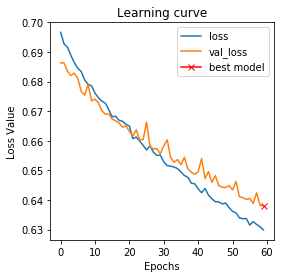

In [11]:
Base = 64
model = model(x_train_skin100.shape[3], x_train_skin100.shape[2], x_train_skin100.shape[1], 64)
model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=.0001),
              metrics=['binary_accuracy'])

model_history = model.fit(x_train_skin100, y_train_skin100,validation_data=(x_test_skin100,y_test_skin100), epochs = 60, batch_size=8, verbose=0)
plot_history(model_history)

### Question 4
- By changing the learning late to .01 or .001, validation loss keeps fluctating. However, with .0001, we will get more stable validation loss but in the same time, it leads to overfitting.    

In [12]:
# LeNet Model
def model_LeNet(img_ch, img_width, img_height,Base):
    model = Sequential()
    model.add(Conv2D(Base, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same',
                     input_shape = (img_width, img_height, img_ch)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(Base*2, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(Base*2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2560064   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

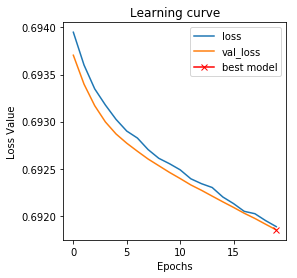

In [13]:
lenet_model = model_LeNet(x_train_skin100.shape[3], x_train_skin100.shape[2], x_train_skin100.shape[1], 32)
lenet_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=.0001),
              metrics=['binary_accuracy'])

lenet_history = lenet_model.fit(x_train_skin100, y_train_skin100,validation_data=(x_test_skin100,y_test_skin100), epochs = 20, batch_size=8, verbose=0)
plot_history(lenet_history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2560064   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

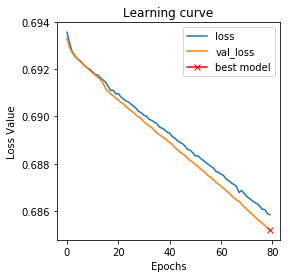

In [14]:
lenet_model = model_LeNet(x_train_skin100.shape[3], x_train_skin100.shape[2], x_train_skin100.shape[1], 32)
lenet_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=.0001),
              metrics=['binary_accuracy'])

lenet_history = lenet_model.fit(x_train_skin100, y_train_skin100,validation_data=(x_test_skin100,y_test_skin100), epochs = 80, batch_size=8, verbose=0)
plot_history(lenet_history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

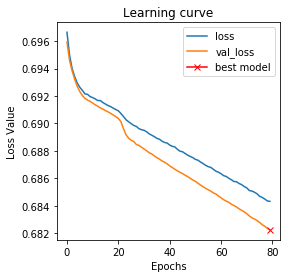

In [15]:
lenet_model = model_LeNet(x_train_skin100.shape[3], x_train_skin100.shape[2], x_train_skin100.shape[1], 8)
lenet_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=.0001),
              metrics=['binary_accuracy'])

lenet_history = lenet_model.fit(x_train_skin100, y_train_skin100,validation_data=(x_test_skin100,y_test_skin100), epochs = 80, batch_size=8, verbose=0)
plot_history(lenet_history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

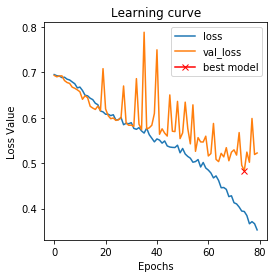

In [16]:
lenet_model = model_LeNet(x_train_skin100.shape[3], x_train_skin100.shape[2], x_train_skin100.shape[1], 8)
lenet_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=.01),
              metrics=['binary_accuracy'])

lenet_history = lenet_model.fit(x_train_skin100, y_train_skin100,validation_data=(x_test_skin100,y_test_skin100), epochs = 80, batch_size=8, verbose=0)
plot_history(lenet_history)

### Question 5
- A - Training accuracy is 0.564 and Validation accuracy is 0.56. Valdiation loss is lower than training loss over all epochs which infers that our model is underfitting and we still need to do more training or having a more powerful (complex) model to solve this.
- B - The gap between the training loss and validation loss is now reduced as a result of more training, which implies that our model is learning and getting more familiar with training data.
- C - As a result of reducing the base, we are making the model simpler and getting back to the first case of underfitting.
- D - Model is learning faster in terms of training data but this led to oscillation in validation loss(more instability)  which led to **overfitting** as training loss is decreasing, but validation loss started to increase back after decreasing. 
- E - The function of the first two conv layers is to extract features from the data. First conv will extract low level features in the images like vertical/horizontal lines, edges, colors, etc. With an added layer the architecture becomes capable of recognizing high level features (tectures, shapes, ), giving the network a better understanding of the input images.
- F - The last two fully connected layers (Dense layers) enables the model to perform classification by learning non-linear combination of extracted features from conv layers. 
- G - LeNet has conv layers which are better than fully connected layers especially in the early stage to detect low level features like vertical/horizontal lines and also in terms of number of parameters. Furthermore, LeNet has pooling layers which are good for extracting dominant features which are rotational and positional invariant.
- H - It depends mainly on the number of classes in the data and also the nature of the task. 
        For regression tasks, we can use linear activation. 
        For classification tasks, we can use sigmoid, tanh, softmax. 
Number of neuorn depends mainly on number of class in data, but also choise of activation affect that. 
For example in binary classification, we can have one neuron with sigmoid or tanh, or two neurons with softmax activation. 
For multi-class classification, we would choose number of neurons similiar to number of class in data with softmax activation in each neuron. 

In [5]:
skin_data_path = '/Lab1/Skin/'                          # Path to data root. Inside this path,
x_train_skin128, x_test_skin128, y_train_skin128, y_test_skin128 = get_data(skin_data_path, 128, 128, 'Mel', 'Nev')

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Reading: 0/1000  of train images
Reading: 200/1000  of train images
Reading: 400/1000  of train images
Reading: 600/1000  of train images
Reading: 800/1000  of train images
Reading: 0/200 of test images
Reading: 100/200 of test images


In [18]:
# AlexNet Model
def model_AlexNet(img_ch, img_width, img_height, Base):
    
    model = Sequential()
    
    model.add(Conv2D(filters=Base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=Base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=Base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=Base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=Base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

#### Task 6A 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)      

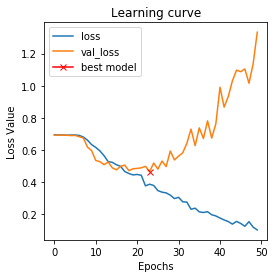

In [19]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 32)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 50, batch_size=8, verbose=0)
plot_history(alexnet_history)

#### Task 6B

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)       

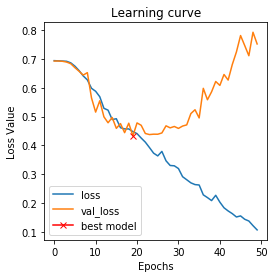

In [20]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 16)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 50, batch_size=8, verbose=0)
plot_history(alexnet_history)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)       

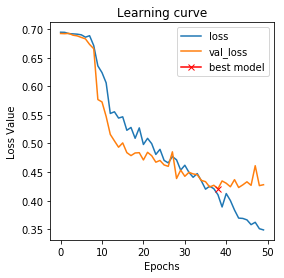

In [21]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 50, batch_size=8, verbose=0)
plot_history(alexnet_history)

#### Task 6C

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_24 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_25 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)       

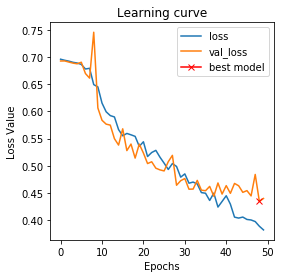

In [22]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 50, batch_size=16, verbose=0)
plot_history(alexnet_history)

#### Task 6D

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_32 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_33 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)      

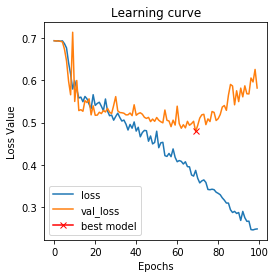

In [23]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 128, 128, 4)       40        
_________________________________________________________________
activation_40 (Activation)   (None, 128, 128, 4)       0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 8)         296       
_________________________________________________________________
activation_41 (Activation)   (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 16)      

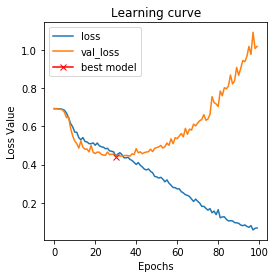

In [24]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 4)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 128, 2)       20        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 2)       0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 4)         76        
_________________________________________________________________
activation_49 (Activation)   (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 8)       

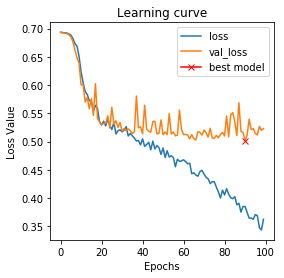

In [25]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 2)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_56 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_57 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)      

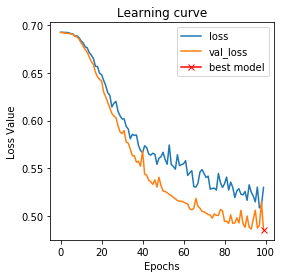

In [26]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.00001),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

#### FInal Model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_64 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_65 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 32)      

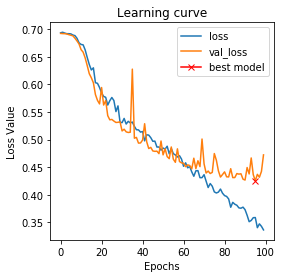

In [27]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.00004),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

#### Task 6D SGD

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_72 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_73 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 32)      

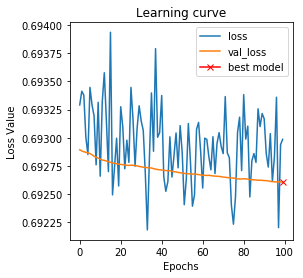

In [28]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=0.00004),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

In [50]:
print(alexnet_model.evaluate(x_train_skin128,y_train_skin128))
print(alexnet_model.evaluate(x_test_skin128,y_test_skin128))

1000/1000 [==============================] - 0s 153us/sample - loss: 0.7203 - binary_accuracy: 0.7860
[0.7202812728881836, 0.786]
200/200 [==============================] - 0s 127us/sample - loss: 0.7127 - binary_accuracy: 0.7950
[0.7127072477340698, 0.795]


#### Task 6D RMSProp 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_88 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_89 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 32)      

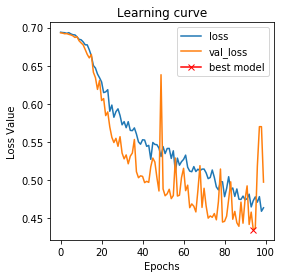

In [30]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(lr=0.00004),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

In [51]:
print(alexnet_model.evaluate(x_train_skin128,y_train_skin128))
print(alexnet_model.evaluate(x_test_skin128,y_test_skin128))

1000/1000 [==============================] - 0s 217us/sample - loss: 0.7203 - binary_accuracy: 0.7860
[0.7202812728881836, 0.786]
200/200 [==============================] - 0s 272us/sample - loss: 0.7127 - binary_accuracy: 0.7950
[0.7127072477340698, 0.795]


In [37]:
y_test_skin128_hinge = copy.deepcopy(y_test_skin128)
y_train_skin128_hinge = copy.deepcopy(y_train_skin128)
y_test_skin128_hinge[y_test_skin128 == 0] = -1
y_train_skin128_hinge[y_train_skin128 == 0] = -1
y_test_skin128_hinge
y_test_skin128

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1], dtype=int32)

#### Task 6E 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_112 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_113 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 32)      

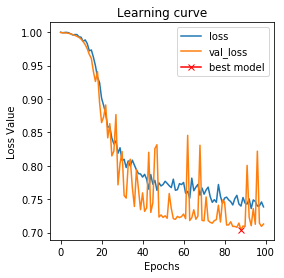

In [45]:
alexnet_model = model_AlexNet(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 8)
alexnet_model.compile(loss='hinge',
              optimizer = RMSprop(lr=0.00004),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_skin128, y_train_skin128_hinge,validation_data=(x_test_skin128,y_test_skin128_hinge), epochs = 100, batch_size=8, verbose=0)
plot_history(alexnet_history)

### Question 6 
- A - It is totally overfitting. 
- B - With base = 16, it is still overfitting. However, with base = 8, the model starts to perform well. 
- C - With base = 8, and batch size = 16, fluctuations of training and validation losses have increased. But, the model is still doing fine. 
- D - The classification accuracy for the best model is 45.623 % and it not overfitting. The classification accuracy for the model with optimizer algorithm as SGD is 69.27 % and there is a very high fluctuation in the training loss. The classification accuracy for the model with optimizer algorithm as RMSProp is 44.46 %, the training loss fluctuation is less in this case, but the validation loss is always less than the training loss and we don’t think this qualifies as a very good model as well.

### Task 7 

In [8]:
def model_vgg16(img_ch, img_width, img_height, Base):
    model = Sequential([
    Conv2D(Base, (3, 3), input_shape=(img_width, img_height, img_ch), padding='same', activation='relu'),
    Conv2D(Base, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*2, (3, 3), activation='relu', padding='same'),
    Conv2D(Base*2, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

    model.summary()
    return model

#### Best Model - VGG 16 - Optimizer - Adam 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 128, 128, 2)       20        
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 128, 128, 2)       38        
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 64, 64, 4)         76        
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 64, 64, 4)         148       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 32, 32, 8)       

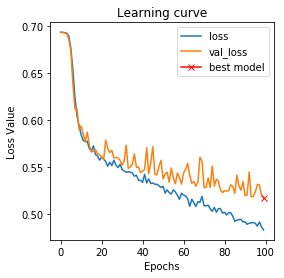

In [26]:
vgg16_model = model_vgg16(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 2)
vgg16_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.00004),
              metrics=['binary_accuracy'])
vgg16_history = vgg16_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(vgg16_history)

In [27]:
print(vgg16_model.evaluate(x_train_skin128, y_train_skin128))
print(vgg16_model.evaluate(x_test_skin128,y_test_skin128))

1000/1000 [==============================] - 0s 213us/sample - loss: 0.4759 - binary_accuracy: 0.7720
[0.4758912696838379, 0.772]
200/200 [==============================] - 0s 218us/sample - loss: 0.5174 - binary_accuracy: 0.7650
[0.5174082279205322, 0.765]


#### VGG 16 - Optimizer - SGD 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 128, 128, 2)       20        
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 128, 128, 2)       38        
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 64, 64, 4)         76        
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 64, 64, 4)         148       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 32, 32, 8)       

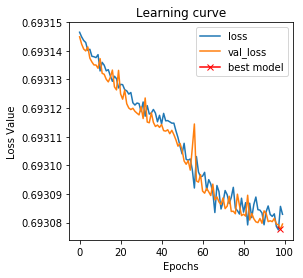

In [28]:
vgg16_model = model_vgg16(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 2)
vgg16_model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=0.00004),
              metrics=['binary_accuracy'])
vgg16_history = vgg16_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(vgg16_history)

#### VGG 16 - Optimizer - RMSProp 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 128, 128, 2)       20        
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 128, 128, 2)       38        
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 64, 64, 4)         76        
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 64, 64, 4)         148       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 32, 32, 8)       

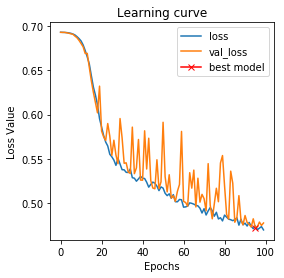

In [30]:
vgg16_model = model_vgg16(x_train_skin128.shape[3], x_train_skin128.shape[2], x_train_skin128.shape[1], 2)
vgg16_model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(lr=0.00004),
              metrics=['binary_accuracy'])
vgg16_history = vgg16_model.fit(x_train_skin128, y_train_skin128,validation_data=(x_test_skin128,y_test_skin128), epochs = 100, batch_size=8, verbose=0)
plot_history(vgg16_history)

### Question 7 

After finding the best hyperparameters, we compared the performance of **VGG16** with different optimaizers. 
- With the optimizer as adam, the validation loss for the best model  was 0.5174.
- With the optimizer as SGD, the validation loss for the best model  was 0.693.
- With the optimizer as RMSProp, the validation loss for the best model was 0.471, the validation loss curve fluctuation is high. 
- None of the models are overfitting. 



### Question 7 - Part 2 

Comparing the results of LeNet, Alexnet and VGG16 with the optimizer as SGD.
- For the LeNet model the validation loss for the best model was 0.682. The validation loss was less than the training loss over all epochs.  
- For the Alexnet the validation loss for the best model was 0.692. The validation loss curve is almost a straight line, this indicates that the model actually did not learn much. 
- For the VGG16 model the validation for the best model was 0.69308. 


### Task 8

In [6]:
bone_data_path = '/Lab1/Bone/'                          # Path to data root. Inside this path,
x_train_bone128, x_test_bone128, y_train_bone128, y_test_bone128 = get_data(bone_data_path, 128, 128, 'AFF', 'NFF')

Reading: 0/1072  of train images
Reading: 200/1072  of train images
Reading: 400/1072  of train images
Reading: 600/1072  of train images
Reading: 800/1072  of train images
Reading: 1000/1072  of train images
Reading: 0/140 of test images
Reading: 100/140 of test images


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 128, 128, 4)       40        
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 8)                 65544     
_________________________________________________________________
dense_87 (Dense)             (None, 1)               

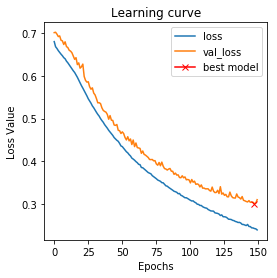

In [73]:
lenet_model = model_LeNet(x_train_bone128.shape[3], x_train_bone128.shape[2], x_train_bone128.shape[1], 4)
lenet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=.00001),
              metrics=['binary_accuracy'])

lenet_history = lenet_model.fit(x_train_bone128, y_train_bone128,validation_data=(x_test_bone128,y_test_bone128), epochs = 150, batch_size=8, verbose=0)
plot_history(lenet_history)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 128, 128, 4)       40        
_________________________________________________________________
activation_136 (Activation)  (None, 128, 128, 4)       0         
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 64, 64, 8)         296       
_________________________________________________________________
activation_137 (Activation)  (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 32, 32, 16)      

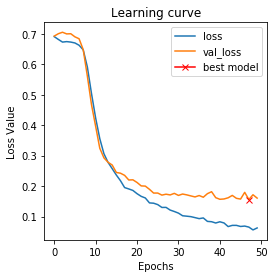

In [76]:
alexnet_model = model_AlexNet(x_train_bone128.shape[3], x_train_bone128.shape[2], x_train_bone128.shape[1], 4)
alexnet_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.00004),
              metrics=['binary_accuracy'])
alexnet_history = alexnet_model.fit(x_train_bone128, y_train_bone128,validation_data=(x_test_bone128,y_test_bone128), epochs = 50, batch_size=8, verbose=0)
plot_history(alexnet_history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 2)       20        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 2)       38        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 4)         76        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 4)         148       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 8)        

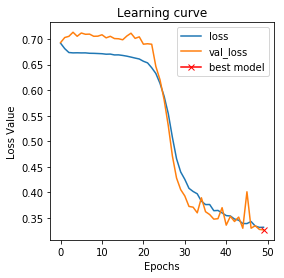

In [11]:
vgg16_model = model_vgg16(x_train_bone128.shape[3], x_train_bone128.shape[2], x_train_bone128.shape[1], 2)
vgg16_model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.00004),
              metrics=['binary_accuracy'])
vgg16_history = vgg16_model.fit(x_train_bone128, y_train_bone128,validation_data=(x_test_bone128,y_test_bone128), epochs = 50, batch_size=8, verbose=0)
plot_history(vgg16_history)

### Task 9 
- As a result of previous expriements, we can see that it is easier to get lower loss for bone data rather than skin data, so bone data is better classified. TO make sure that results are reliable, we should have a test set which shouldn't be used exept only for the final test just to make sure that models have the same behaviour as we expected. We can do this by taking percentage of the data as a test set in the beginning and test on it at the end.  

### Bouns Task

In [13]:
# Data Loader
# Assigning labels two images; those images contains pattern1 in their filenames
# will be labeled as class 0 and those with pattern2 will be labeled as class 1.
def gen_labels(im_name):
    for i in range(1,10):
        if 'C'+ str(i) in im_name:
            Label = np.array([i])
            break
    return Label

# reading and resizing the training images with their corresponding labels
def train_data(train_data_path, train_list, img_w, img_h):
    train_img = []       
    for i in range(len(train_list)):
        image_name = train_list[i]
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img.append([np.array(img), gen_labels(image_name)]) 
        
        if i % 200 == 0:
             print('Reading: {0}/{1}  of train images'.format(i, len(train_list)))
             
    shuffle(train_img)
    return train_img

# reading and resizing the testing images with their corresponding labels
def test_data(test_data_path, test_list, img_w, img_h):
    test_img = []       
    for i in range(len(test_list)):
        image_name = test_list[i]
        img = imread(os.path.join(test_data_path, image_name), as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img.append([np.array(img), gen_labels(image_name)]) 
        
        if i % 100 == 0:
            print('Reading: {0}/{1} of test images'.format(i, len(test_list)))
             
    shuffle(test_img)   
    return test_img

# Instantiating images and labels for the model.
def get_train_test_data(train_data_path, test_data_path, train_list, test_list, img_w, img_h):
    
    Train_data = train_data(train_data_path, train_list, img_w, img_h)
    Test_data = test_data(test_data_path, test_list, img_w, img_h)
       
    Train_Img = np.zeros((len(train_list), img_h, img_w), dtype = np.float32)
    Test_Img = np.zeros((len(test_list), img_h, img_w), dtype = np.float32)
    
    Train_Label = np.zeros((len(train_list)), dtype = np.int32)
    Test_Label = np.zeros((len(test_list)), dtype = np.int32)
    
    for i in range(len(train_list)):
        Train_Img[i] = Train_data[i][0]
        Train_Label[i] = Train_data[i][1]
        
    Train_Img = np.expand_dims(Train_Img, axis = 3)   
    
    for j in range(len(test_list)):
        Test_Img[j] = Test_data[j][0]
        Test_Label[j] = Test_data[j][1]
        
    Test_Img = np.expand_dims(Test_Img, axis = 3)
        
    return Train_Img, Test_Img, Train_Label, Test_Label

def get_data(data_path, img_w, img_h):
    train_data_path = os.path.join(data_path, 'train')   
    test_data_path = os.path.join(data_path, 'test')

    train_list = os.listdir(train_data_path)
    test_list = os.listdir(test_data_path)
    x_train, x_test, y_train, y_test = get_train_test_data(
        train_data_path, test_data_path,
        train_list, test_list, img_w, img_h)
    return x_train, x_test, y_train, y_test

In [14]:
x_ray_data_path = '/Lab1/X_ray/'                          # Path to data root. Inside this path,
x_train_ray128, x_test_ray28, y_train_ray128, y_test_ray128 = get_data(x_ray_data_path, 128, 128)

Reading: 0/5780  of train images
Reading: 200/5780  of train images
Reading: 400/5780  of train images
Reading: 600/5780  of train images
Reading: 800/5780  of train images
Reading: 1000/5780  of train images
Reading: 1200/5780  of train images
Reading: 1400/5780  of train images
Reading: 1600/5780  of train images
Reading: 1800/5780  of train images
Reading: 2000/5780  of train images
Reading: 2200/5780  of train images
Reading: 2400/5780  of train images
Reading: 2600/5780  of train images
Reading: 2800/5780  of train images
Reading: 3000/5780  of train images
Reading: 3200/5780  of train images
Reading: 3400/5780  of train images
Reading: 3600/5780  of train images
Reading: 3800/5780  of train images
Reading: 4000/5780  of train images
Reading: 4200/5780  of train images
Reading: 4400/5780  of train images
Reading: 4600/5780  of train images
Reading: 4800/5780  of train images
Reading: 5000/5780  of train images
Reading: 5200/5780  of train images
Reading: 5400/5780  of train images

In [10]:
y_test_ray128

array([4, 1, 5, 7, 9, 5, 9, 7, 8, 7, 4, 4, 4, 6, 5, 2, 5, 6, 2, 3, 9, 7,
       4, 2, 7, 7, 4, 8, 5, 9, 2, 2, 2, 2, 5, 8, 4, 4, 1, 9, 4, 7, 2, 8,
       3, 3, 1, 2, 8, 2, 4, 2, 2, 8, 6, 5, 5, 9, 4, 1, 4, 4, 7, 3, 7, 8,
       8, 9, 6, 3, 8, 7, 8, 7, 7, 3, 3, 2, 5, 1, 4, 9, 7, 1, 1, 8, 6, 9,
       1, 1, 2, 8, 8, 6, 1, 6, 2, 5, 9, 4, 1, 5, 3, 2, 2, 5, 4, 3, 4, 9,
       3, 1, 4, 2, 6, 2, 9, 3, 2, 5, 2, 2, 1, 4, 5, 9, 6, 2, 7, 1, 7, 5,
       6, 4, 7, 8, 7, 6, 8, 6, 3, 6, 9, 4, 3, 1, 4, 9, 6, 8, 6, 5, 5, 4,
       1, 2, 3, 9, 9, 2, 6, 4, 8, 9, 6, 6, 5, 5, 5, 5, 1, 4, 6, 2, 8, 9,
       2, 9, 2, 4, 9, 1, 9, 1, 3, 5, 5, 6, 9, 2, 9, 1, 4, 1, 3, 7, 5, 6,
       6, 1, 6, 9, 1, 1, 8, 9, 2, 3, 8, 4, 3, 4, 5, 7, 1, 5, 1, 7, 8, 2,
       8, 8, 7, 3, 3, 9, 2, 3, 4, 7, 9, 9, 2, 2, 7, 1, 1, 5, 9, 5, 6, 4,
       4, 5, 7, 5, 4, 4, 5, 2, 6, 5, 9, 6, 1, 8, 6, 5, 7, 6, 6, 6, 8, 5,
       3, 6, 7, 9, 3, 1, 3, 1, 3, 5, 6, 2, 6, 7, 3, 6, 6, 2, 9, 3, 7, 5,
       1, 9, 7, 5, 5, 8, 9, 5, 9, 7, 9, 5, 3, 7, 8,

In [13]:
# LeNet Model
def model_LeNet(img_ch, img_width, img_height,Base):
    model = Sequential()
    model.add(Conv2D(Base, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same',
                     input_shape = (img_width, img_height, img_ch)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(Base*2, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(Base*2, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                262160    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

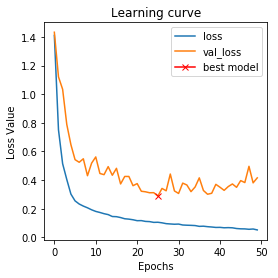

In [14]:
from tensorflow.keras.utils import to_categorical
y_train_ray128_binary = to_categorical(y_train_ray128)
y_test_ray128_binary = to_categorical(y_test_ray128)
lenet_model = model_LeNet(x_train_ray128.shape[3], x_train_ray128.shape[2], x_train_ray128.shape[1], 8)
lenet_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=.0001),
              metrics=['categorical_accuracy'])

lenet_history = lenet_model.fit(x_train_ray128, y_train_ray128_binary,validation_data=(x_test_ray28,y_test_ray128_binary), epochs = 50, batch_size=8, verbose=0)
plot_history(lenet_history)

In [24]:
print(lenet_model.evaluate(x_train_ray128,y_train_ray128_binary))
print(lenet_model.evaluate(x_test_ray28,y_test_ray128_binary))

5780/5780 [==============================] - 2s 323us/sample - loss: 0.0785 - categorical_accuracy: 0.9746
[0.07846355081171726, 0.9745675]
450/450 [==============================] - 0s 334us/sample - loss: 0.3717 - categorical_accuracy: 0.8867
[0.37174318691094715, 0.88666666]


In [25]:
# AlexNet Model
def model_AlexNet(img_ch, img_width, img_height, Base):
    
    model = Sequential()
    
    model.add(Conv2D(filters=Base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=Base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=Base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=Base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=Base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()   
    return model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)      

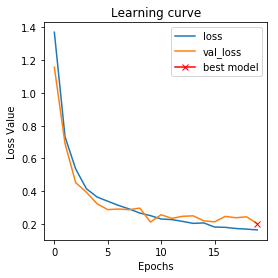

In [26]:
alexnet_model = model_AlexNet(x_train_ray128.shape[3], x_train_ray128.shape[2], x_train_ray128.shape[1], 8)
alexnet_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=.0001),
              metrics=['categorical_accuracy'])

alexnet_history = alexnet_model.fit(x_train_ray128, y_train_ray128_binary,validation_data=(x_test_ray28,y_test_ray128_binary), epochs = 20, batch_size=8, verbose=0)
plot_history(alexnet_history)

In [27]:
print(alexnet_model.evaluate(x_train_ray128,y_train_ray128_binary))
print(alexnet_model.evaluate(x_test_ray28,y_test_ray128_binary))

5780/5780 [==============================] - 2s 276us/sample - loss: 0.0852 - categorical_accuracy: 0.9649
[0.0852486735873672, 0.9648789]
450/450 [==============================] - 0s 148us/sample - loss: 0.2033 - categorical_accuracy: 0.9333
[0.20330686590479066, 0.93333334]


In [15]:
def model_vgg16(img_ch, img_width, img_height, Base):
    model = Sequential([
    Conv2D(Base, (3, 3), input_shape=(img_width, img_height, img_ch), padding='same', activation='relu'),
    Conv2D(Base, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*2, (3, 3), activation='relu', padding='same'),
    Conv2D(Base*2, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*4, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    Conv2D(Base*8, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='sigmoid')
    ])

    model.summary()
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 128, 128, 4)       40        
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 128, 128, 4)       148       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 64, 64, 8)         296       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 16)       

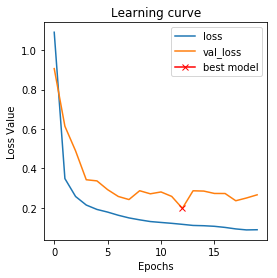

In [18]:
from tensorflow.keras.utils import to_categorical
y_train_ray128_binary = to_categorical(y_train_ray128)
y_test_ray128_binary = to_categorical(y_test_ray128)
vgg16_model = model_vgg16(x_train_ray128.shape[3], x_train_ray128.shape[2], x_train_ray128.shape[1], 4)
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=.0001),
              metrics=['categorical_accuracy'])

vgg16_history = vgg16_model.fit(x_train_ray128, y_train_ray128_binary,validation_data=(x_test_ray28,y_test_ray128_binary), epochs = 20, batch_size=8, verbose=0)
plot_history(vgg16_history)